# 2D Alignment

In [1]:
using Revise
push!(LOAD_PATH, "$(homedir())/Development/")
using JSort
import CSV
using DataFrames

┌ Info: Precompiling JSort [e0ebc282-81fe-11e9-3a6c-c708bf7e9f76]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [13]:
## Load the preprocessed data
#path = "$(homedir())/master/sortering/"
#@time events = loadlabr(path*"sirius");
#parameters = Parameters(path*"si28.yaml");

# Sort the datafile
#@time makeeΔe(events, parameters)
@time makeeΔebin(events, parameters)
#@time ge, gt = makelabr(events, parameters);
#mat = copy(ge.matrix);


  5.975019 seconds (26.64 M allocations: 631.099 MiB, 23.84% gc time)


## Old OMatrix Method

In [1]:
function plotmat(matrix)
    G = convert(Array{Float64, 2}, matrix)
    log10transform!(G)
    pl = heatmap(G', c=:viridis, yticks=([1:length(chns);], chns))
end

function plotstrip(strips)
    G = hcat(strips...)
    G = convert(Array{Float64, 2}, G)
    log10transform!(G)
    pl = heatmap(G', c=:viridis)
end

function log10transform!(G)
    G[G .> 0] .= log10.(G[G .> 0])
    G[G .≤ 0] .= NaN
end

function log10transform(V)
    G = zeros(size(V))
    G[V .> 0] .= log10.(G[V .> 0])
    G[V .≤ 0] .= NaN
    G
end


log10transform (generic function with 1 method)

In [ ]:
heatmap(log10transform(medebf[1, 1].matrix'), color=:viridis)

In [ ]:
function plotmat(matrix)
    G = convert(Array{Float64, 2}, matrix)
    log10transform!(G)
    pl = heatmap(G', c=:viridis, yticks=([1:length(chns);], chns))
end

function plotstrip(strips)
    G = hcat(strips...)
    G = convert(Array{Float64, 2}, G)
    log10transform!(G)
    pl = heatmap(G', c=:viridis, size=(1000, 1000))
end

function log10transform!(G)
    G[G .> 0] .= log10.(G[G .> 0])
    G[G .≤ 0] .= NaN
end

function log10transform(V)
    G = V[1:end]
    G[G .> 0] .= log10.(G[G .> 0])
    G[G .≤ 0] .= NaN
    G
en

In [ ]:
@recipe f(::Type{OMatrix{Array{Int64, 2}}}, omatrix::OMatrix{Array{Int64, 2}}) = log10transform(omatrix.matrix')

In [ ]:
plot(refmat.matrix, seriestype=:image)

In [2]:
function plotbox(edges)
    (startx, stopx), (starty, stopy) = edges
    plot!([startx, stopx, stopx, startx, startx], 
        [starty, starty, stopy, stopy, starty], color=:steelblue, legend=false)
end

function plotbox(subarray::SubArray)
    x, y = subarray.indices
    plotbox(((first(x), last(x)), (first(y), last(y))))
end

plotbox (generic function with 2 methods)

In [ ]:
edges = boxbounds(medebf[1, 1].matrix, 8)
subarrays = [arraybox(medebf[1, 1].matrix, edge) for edge in edges]
plt = heatmap(medebf[1,1], color=:viridis)
plotbox.(subarrays)
plt

In [ ]:
arrays = splitregions2d(medebf[1, 1].matrix, 20, limit=1000)
plt = heatmap(medebf[1,1], color=:viridis)
plotbox.(arrays)
plt

In [ ]:
heatmap(medebf[1, 1], color=:viridis)
heatmap!(medebf[1, 2], color=:blues)
plotbox(arrays[5])
overlap = featureoverlap2d(arrays[5], medebf[1, 2].matrix, 10)
@show overlap
@show arrays[5].indices
#heatmap(overlap)

In [ ]:
refmat = medebf[1, 1]
tarmat = medebf[1, 5]
ref, tar = featurealign2d(refmat, tarmat, 
    numregions=10, width=100, limit=1000, searchwidth=10)
arrays = splitregions2d(medebf[1, 1], 10, width=100, limit=1000);

In [ ]:
plt = heatmap(xrange(refmat), yrange(refmat), refmat, color=:viridis)
#plt = heatmap!(range(0, 1000, length=size(tarmat.matrix, 1)), yrange(tarmat), tarmat, color=:greens)
plotbox.(arrays)
for (r, t) in zip(ref, tar)
    rx, ry = r
    tx, ty = t
    scatter!([rx, tx], [ry, ty], legend=false, markershape=:dtriangle, markerstrokewidth=0,
    markersize=4)
end
plt

In [ ]:
x, y = zip([([r[1], t[1]], [r[2], t[2]]) for (r, t) in zip(ref, tar)]...)
refx, tarx = zip(x...) .|> collect .|> indextox(x, tarmat)
refy, tary = zip(y...) .|> collect
coeffx = leastsquares(tarx, refx; order=1)
coeffy = leastsquares(tary, refy, order=1)

@show coeffx
@show coeffy
@show trangex = xrange(tarmat)
@show trangey = yrange(tarmat)
@show ttrangex = coeffx[1] .+ trangex.*coeffx[2]
@show ttrangey = coeffy[1] .+ trangey.*coeffy[2]


In [ ]:
bf14 = CSV.read("sirius/medeb1f4.csv", header=["e", "Δe"]);
bf25 = CSV.read("sirius/medeb2f5.csv", header=["e", "Δe"]);

In [ ]:
b = bf14[1:1000, :];
b2 = bf25[1:1000, :];

In [ ]:
 Gadfly.plot(b, x=:e, y=:Δe, Geom.hexbin)

In [ ]:
@df bf25 Plots.plot(:e, :Δe, markerstrokewidth=0, seriestype=:histogram2d, nbins=400, 
                 color=:reds)
@df bf14 Plots.plot!(:e, :Δe, markerstrokewidth=0, seriestype=:histogram2d, nbins=400,
                color=:blues)

## New Method

Load the data

In [6]:
root = "/home/erdos/master/sortering/"
@time reference = CSV.read(root*"sirius/medeb1f1_2.csv", header=["e", "Δe"], datarow=2) |> DataFrame;
@time target = CSV.read(root*"sirius/medeb5f1_2.csv", header=["e", "Δe"], datarow=2) |> DataFrame;

 10.595412 seconds (19.01 M allocations: 925.881 MiB, 3.98% gc time)
  0.009043 seconds (186 allocations: 3.117 MiB)


In [9]:
import PyPlot; const plt = PyPlot
#pygui(true)

PyPlot

In [13]:
import Tables
Tables.table

ArgumentError: ArgumentError: Package Tables not found in current path:
- Run `import Pkg; Pkg.add("Tables")` to install the Tables package.


In [11]:
coefficients = featurealign2d("/home/erdos/master/sortering/sirius/", plot=true);

Error of Linear Regression: 0.05979614541280437
Error of RANSAC absolute_loss: 0.05979614541280437
Error of RANSAC squared_loss: 0.04993534962931733
Optimal is RANSAC squared_loss with 9.099738130791398e-6
Error of Linear Regression: 0.02685251010535561
Error of RANSAC absolute_loss: 0.02685251010535561
Error of RANSAC squared_loss: 0.03586272246857957
Optimal is Linear Regression with 7.0129407074207956e-6
Error of Linear Regression: 0.08089705027299347
Error of RANSAC absolute_loss: 0.08089705027299347
Error of RANSAC squared_loss: 0.059735118097852494
Optimal is RANSAC squared_loss with 8.643727863222697e-6
Error of Linear Regression: 0.20690638326555202
Error of RANSAC absolute_loss: 0.20690638326555202
Error of RANSAC squared_loss: 0.19355216790553406
Optimal is RANSAC squared_loss with 6.719427135482353e-6
Error of Linear Regression: 0.027827062713828503
Error of RANSAC absolute_loss: 0.027827062713828503
Error of RANSAC squared_loss: 0.026428179341084535
Optimal is RANSAC square

ArgumentError: ArgumentError: a 'Array{Float64,2}' is not a table; see `?Tables.table` for ways to treat an AbstractMatrix as a table

In [7]:
#refhist = fit(Histogram, (reference[:e], reference[:Δe]), nbins=1000)
edges = histogram_edges(reference[!, :e], reference[!, :Δe], nbins=1000)
refmat = JSort.histogram(reference[!, :e], reference[!, :Δe], edges...)
tarmat = JSort.histogram(target[!, :e], target[!, :Δe], edges...)
#tarmat = binhist(target[:e], target[:Δe], refhist.edges...);
#refmat = refhist.weights;

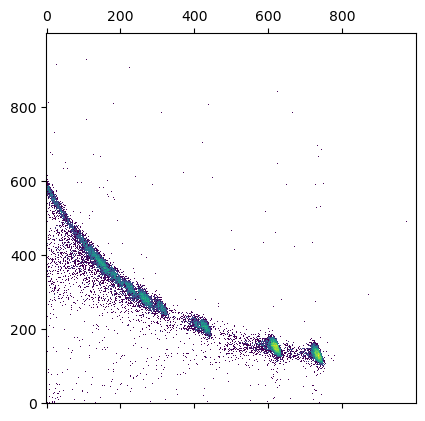

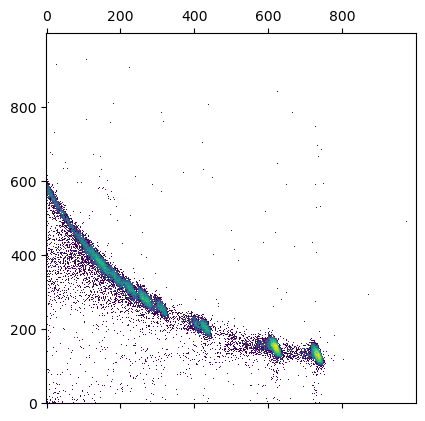

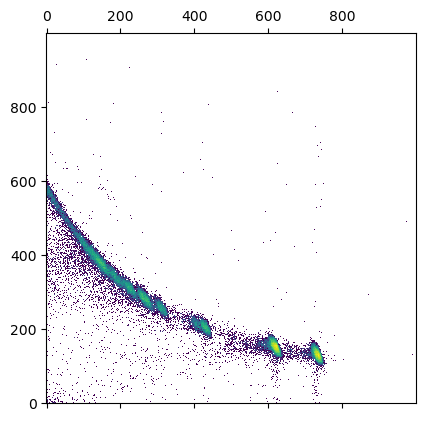

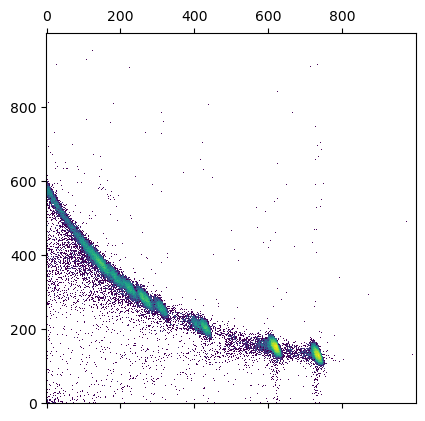

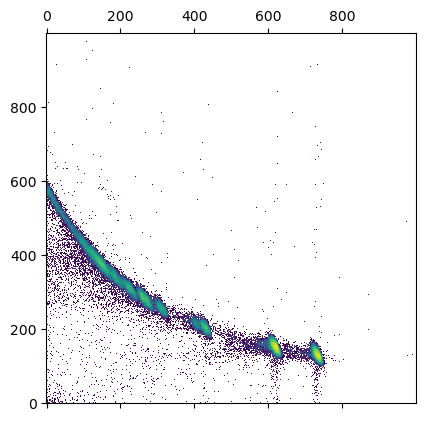

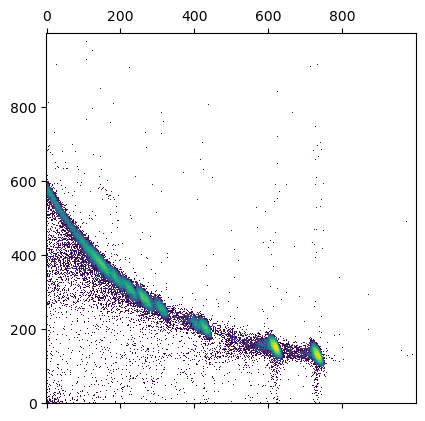

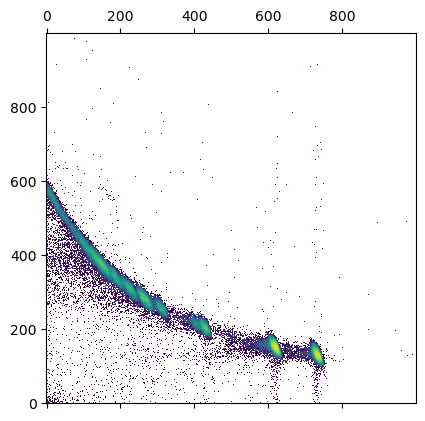

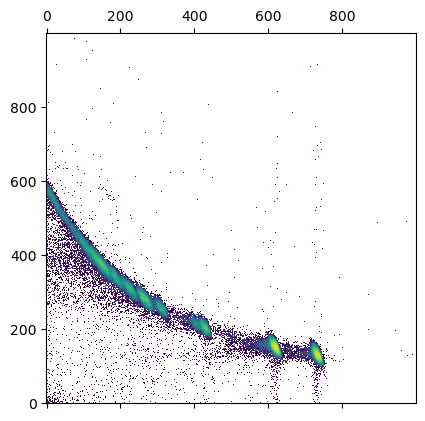

In [27]:
f = 1
reference = CSV.read(root*"sirius/medeb1f$(f)_2.csv", header=["e", "Δe"], datarow=2) |> DataFrame;
edges = histogram_edges(reference[!, :e], reference[!, :Δe], nbins=1000)
total = JSort.histogram(reference[!, :e], reference[!, :Δe], edges...)
for b in 2:8
    mat = CSV.read(root*"sirius/medeb$(b)f$(f)_2.csv", header=["e", "Δe"], datarow=2) |> DataFrame;
    total .+= JSort.histogram(mat[!, :e], mat[!, :Δe], edges...)
    fig, ax = plt.subplots()
    ax.matshow(total' .|> log10)
    ax.invert_yaxis()
end
    
fig, ax = plt.subplots()
ax.matshow(total' .|> log10)
ax.invert_yaxis()

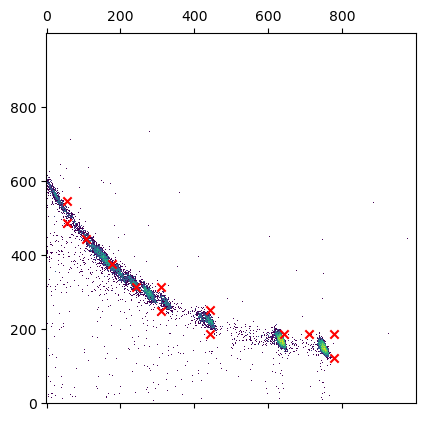

In [109]:
#rpx, tpx, rpy, tpy = featurealign2d(refmat, tarmat, 
#    numregions=15, width=nothing, limit=1000, searchwidth=40)
points = featurealign2d_weighted(refmat, tarmat, numregions=15, width=nothing,
                                 limit=1000, searchwidth=40, weight=ThresholdArea(.2))
rpx, tpx, rpy, tpy, weights = points
# points = featurealign2d_weighted(refmat, tarmat, numregions=15, width=nothing, 
#                                  limit=1000, searchwidth=40, weight=ThresholdSum(.2))
# rpx, tpx, rpy, tpy, weights = points
# @show weights
annotate_plot_2d(tarmat, tpx, tpy)#, weights)
# fig, ax = plt.subplots()
# ax.matshow(transpose(refmat) .|> log10)
# ax.scatter(rpx, rpy, marker="+", c="r")
# ax.invert_yaxis()
# fig, ax = plt.subplots()
# ax.matshow(transpose(tarmat) .|> log10)
# ax.scatter(tpx, tpy, marker="+", c="r")
# ax.invert_yaxis()

# The coefficients are in index-basis. Need them in energy basis
edgesx, edgesy = edges
rpx, tpx = edgesx[rpx], edgesx[tpx]
rpy, tpy = edgesy[rpy], edgesy[tpy]

coeffx, Σx = leastsquares(tpx, rpx, weights; order=1)
coeffy, Σy = leastsquares(tpy, rpy, weights; order=1);
#coeffx = leastsquares(tpx, rpx; order=1)
#coeffy = leastsquares(tpy, rpy; order=1);


In [110]:
 e = @. coeffx[1] + coeffx[2]*target[!, :e]
de = @. coeffy[1] + coeffy[2]*target[!, :Δe]

calibtarget = DataFrame(e=e, Δe=de);
calibmat = JSort.histogram(calibtarget[!, :e], calibtarget[!, :Δe], edges...);
@show err1 = compare_2d(refmat, calibmat)
@show err2 = compare_2d(refmat, tarmat)
@show err1/err2

err1 = compare_2d(refmat, calibmat) = 161272.80692799142
err2 = compare_2d(refmat, tarmat) = 1.0890830007962815e6
err1 / err2 = 0.14808128196847903


0.14808128196847903

In [135]:
using PyCall

X, Y = tpy, rpy
lm = pyimport("sklearn.linear_model")
lr = lm.TheilSenRegressor(fit_intercept=true)
lr = lm.RANSACRegressor()
feat = reshape(X, :, 1)
lr.fit(feat, Y)
hat = lr.predict(feat)
lre = lr.estimator_
@show lre.coef_
@show lre.intercept_
coeffc = [lre.intercept_; lre.coef_...]

lre.coef_ = [1.0762205858812233]
lre.intercept_ = -316.2176570268166


2-element Array{Float64,1}:
 -316.2176570268166   
    1.0762205858812233

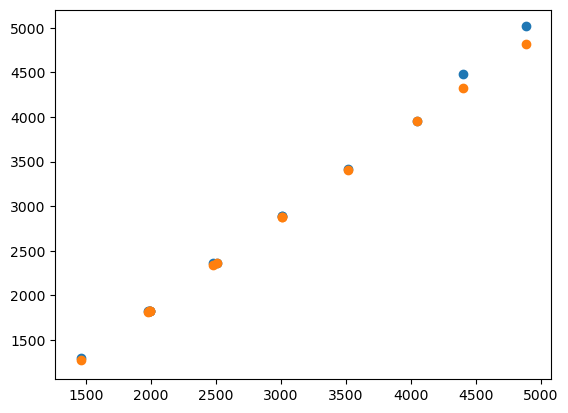

PyObject <matplotlib.collections.PathCollection object at 0x7fdb121a8880>

In [121]:
scatter(X, Y)
scatter(X, hat)

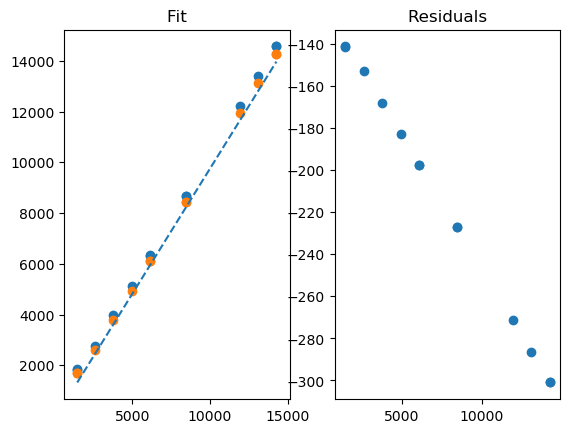

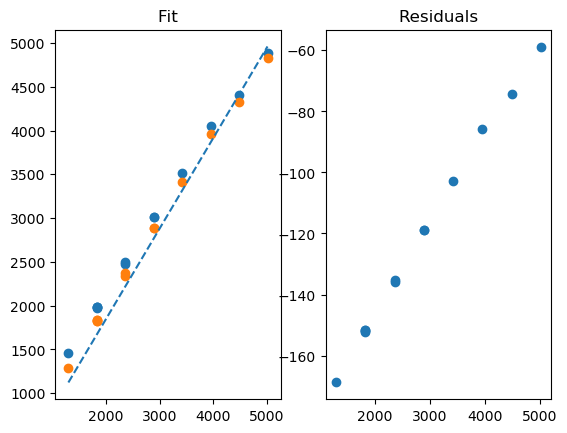

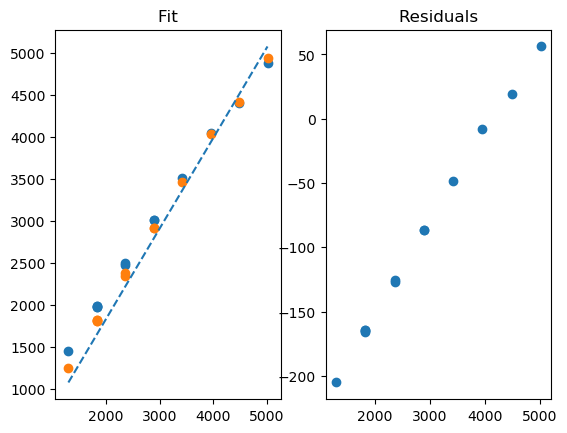

2-element Array{PyObject,1}:
 PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fdb118a2d60>
 PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x7fdb11847580>

In [136]:
plotresiduals(rpx, tpx, coeffx)
plotresiduals(rpy, tpy, coeffy)
plotresiduals(rpy, tpy, coeffc)

  0.045063 seconds (185 allocations: 4.249 MiB)
  0.040276 seconds (167 allocations: 4.718 MiB)
OLS - Error ratio: 1.6260564230801573
TheilSen - Error ratio: 2.2828727296202347
RANSAC - Error ratio: 1.6260564230801573
RANSAC absolute_loss - Error ratio: 1.6260564230801573
RANSAC squared_loss - Error ratio: 1.1114408847726793


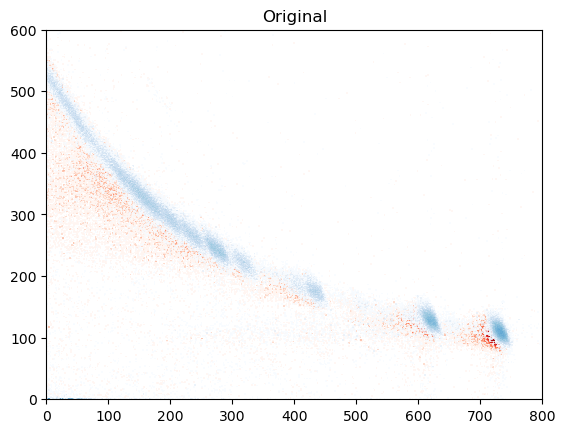

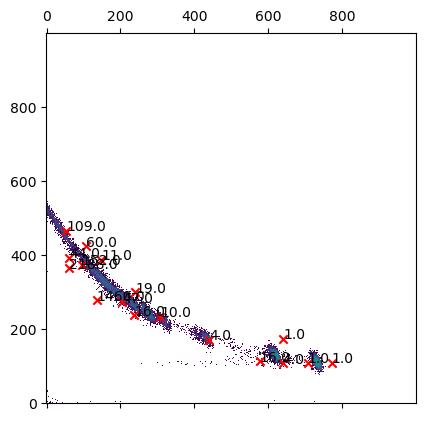

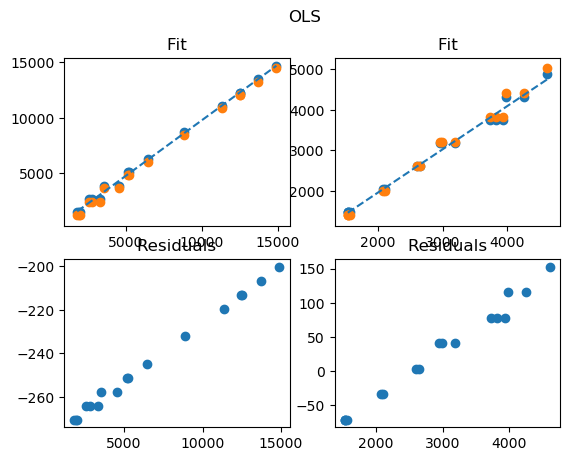

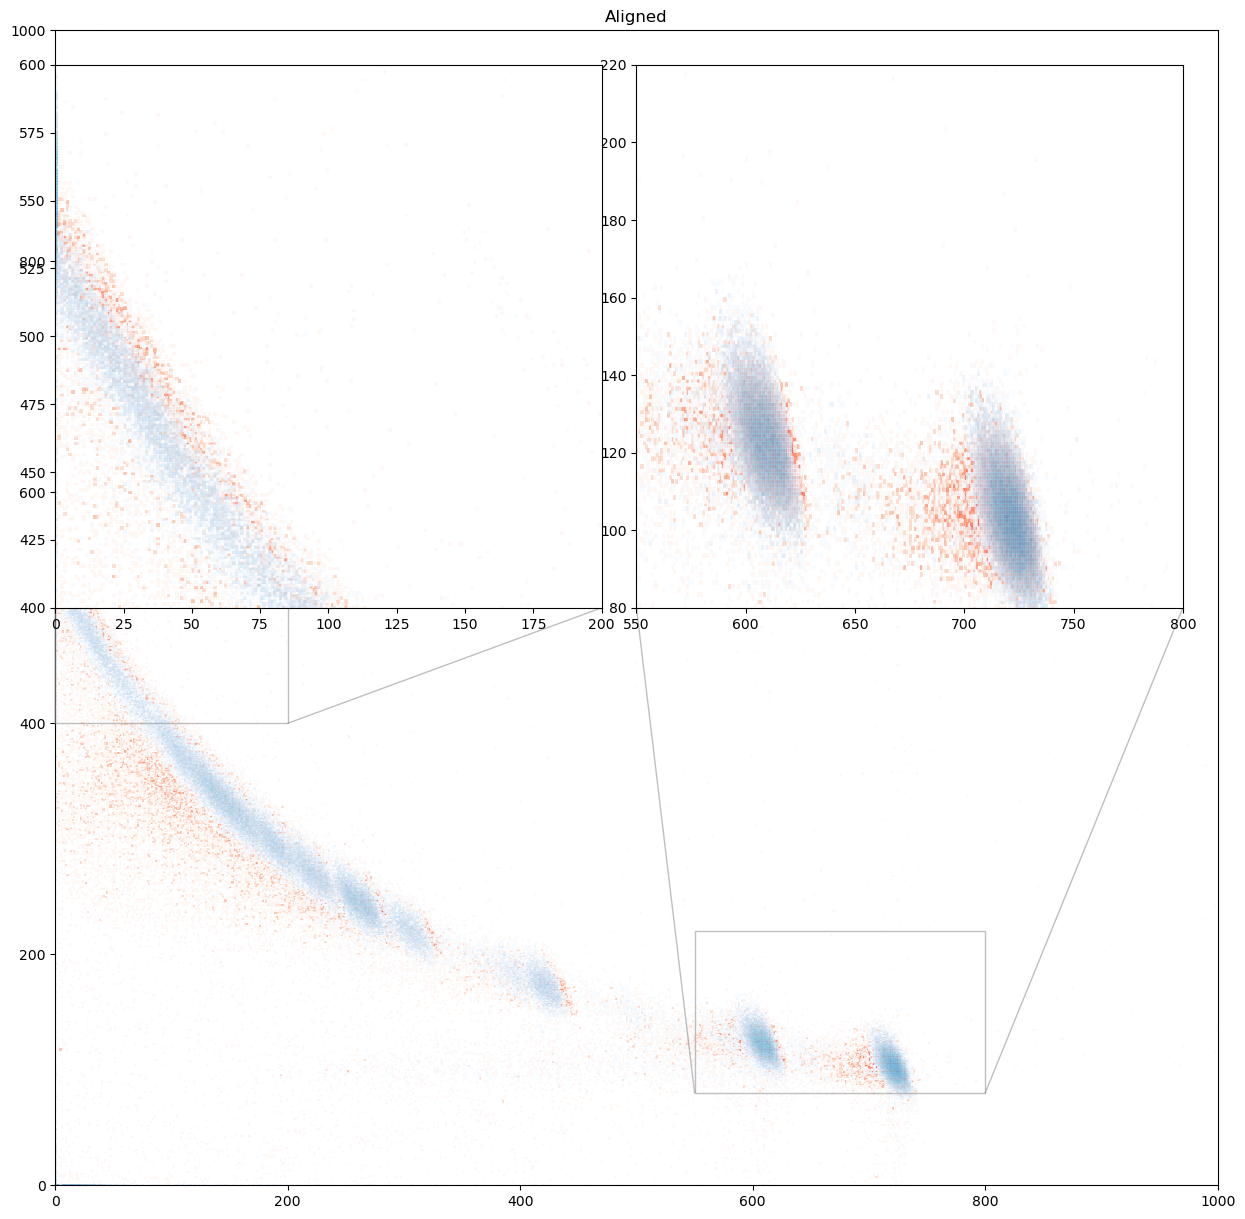

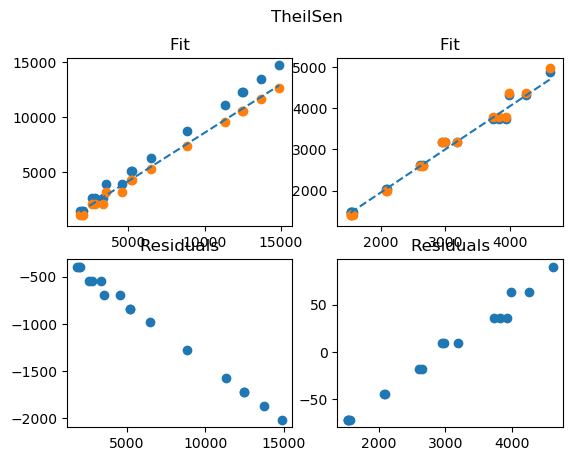

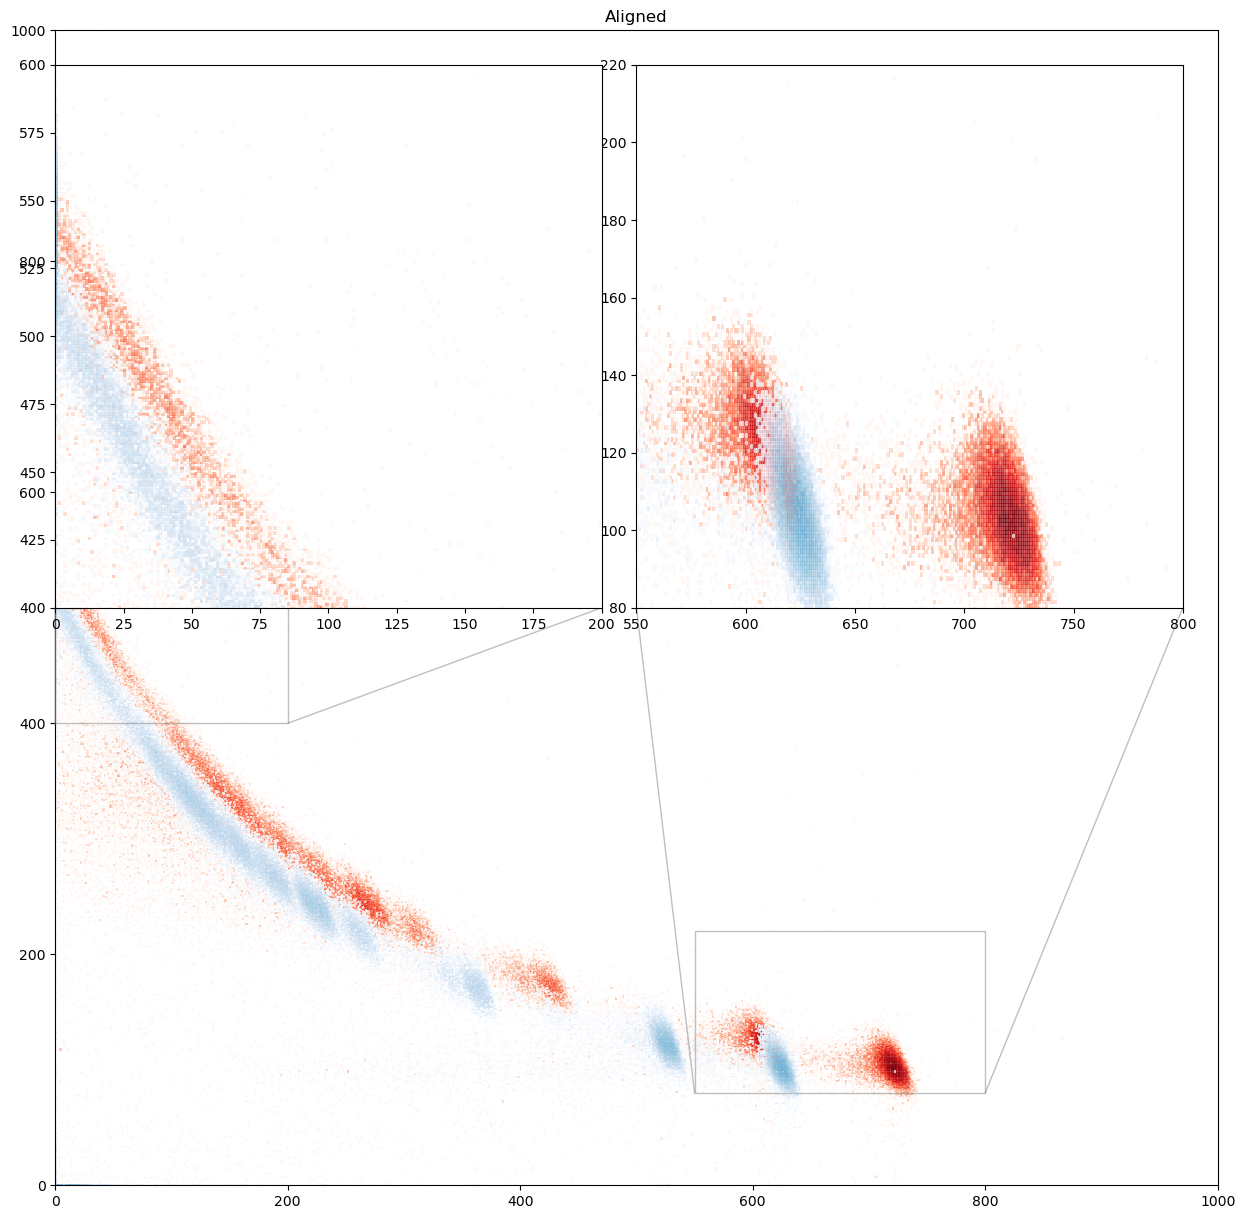

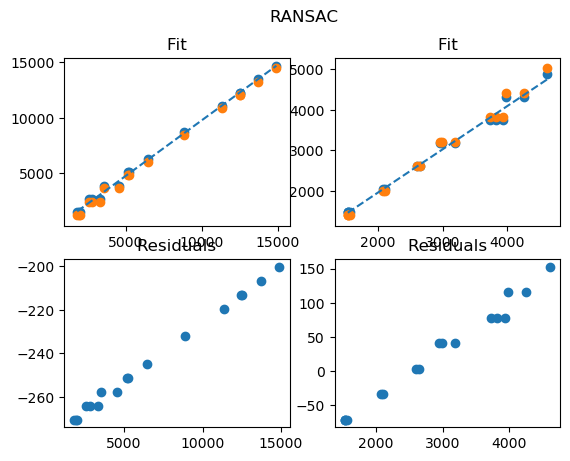

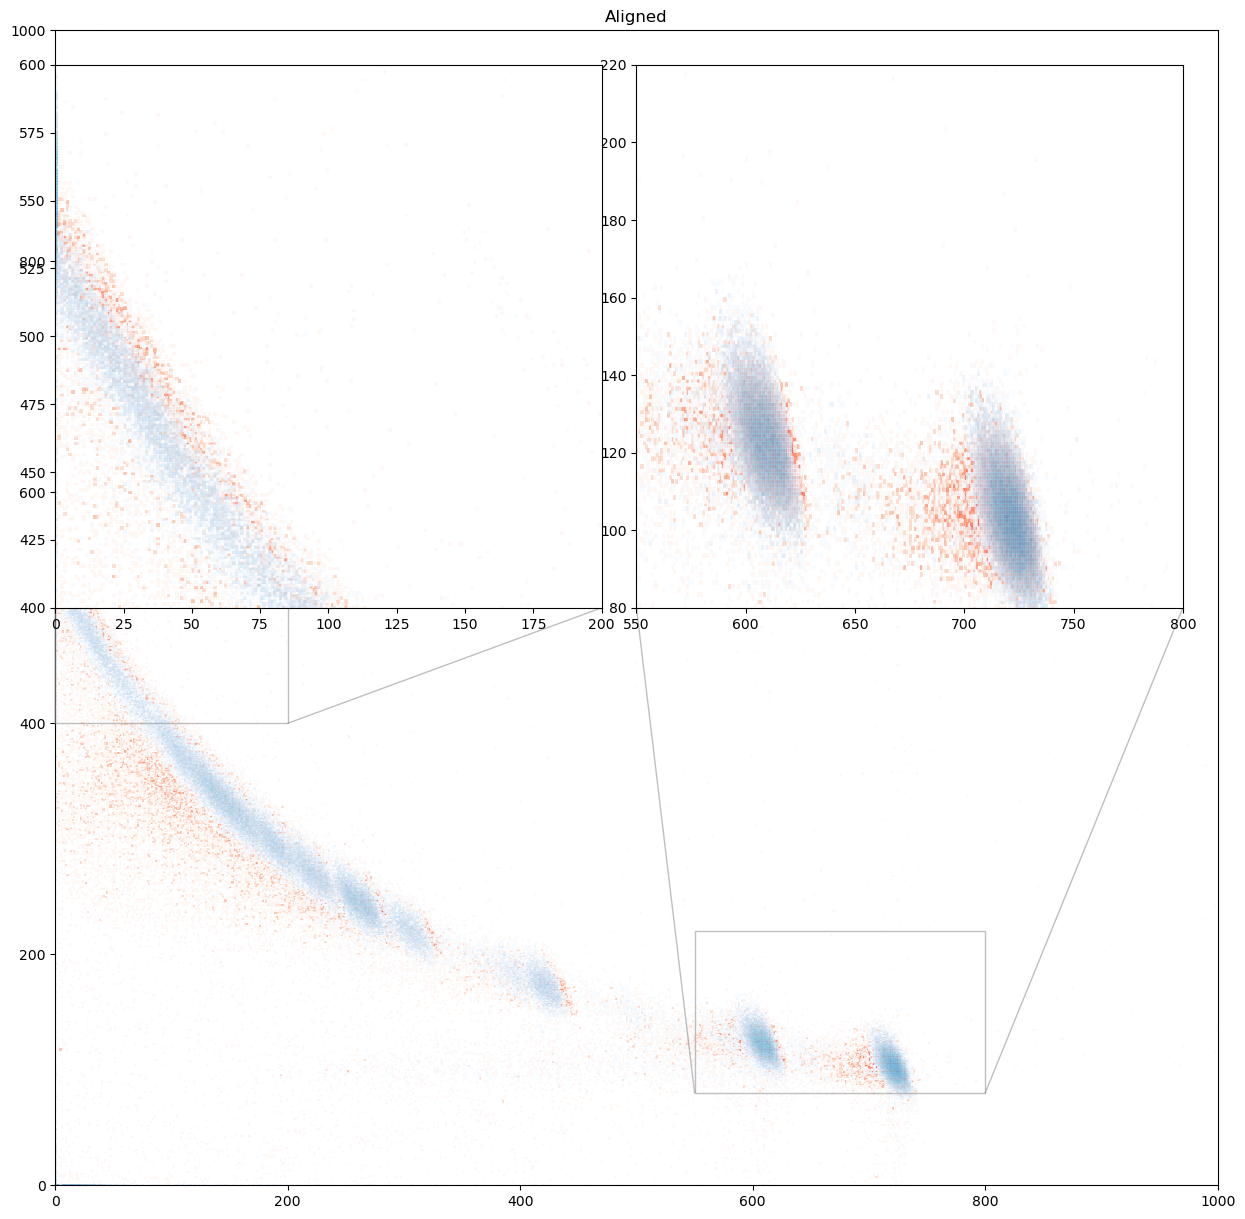

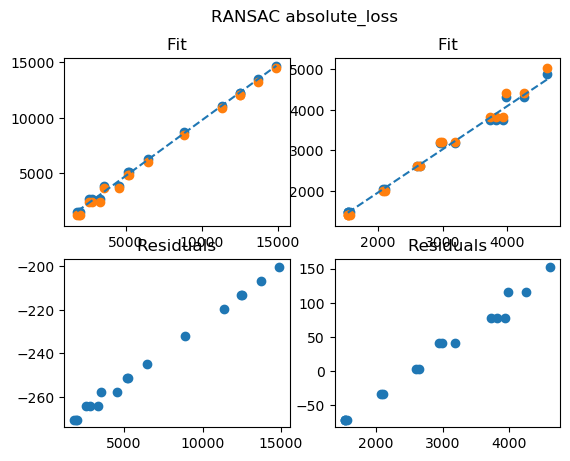

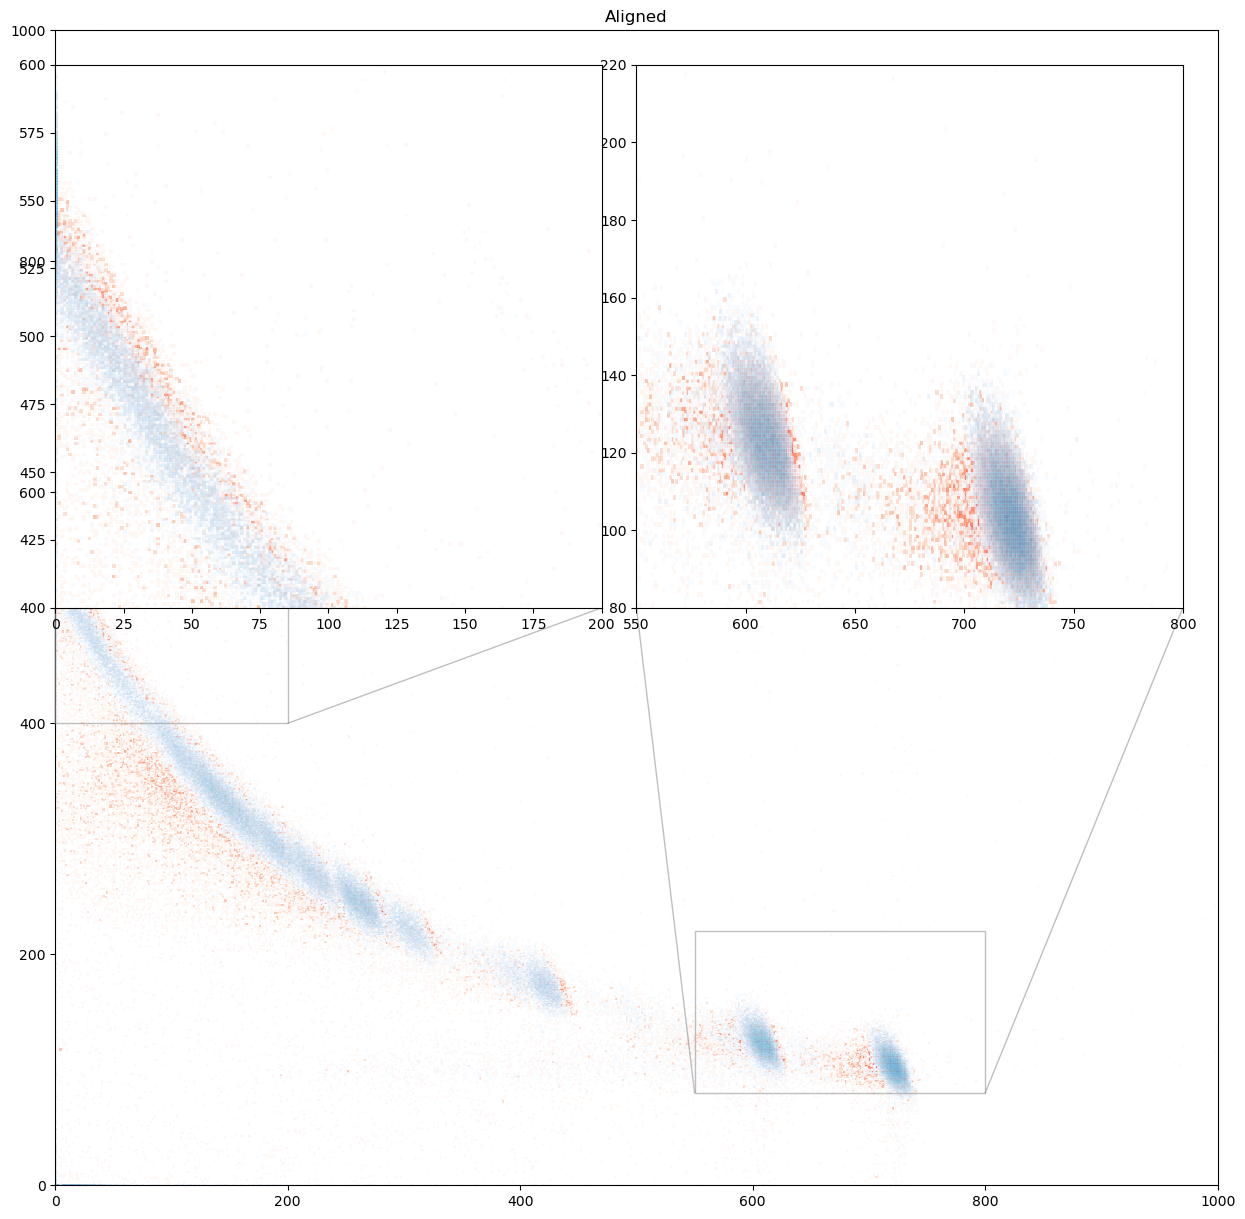

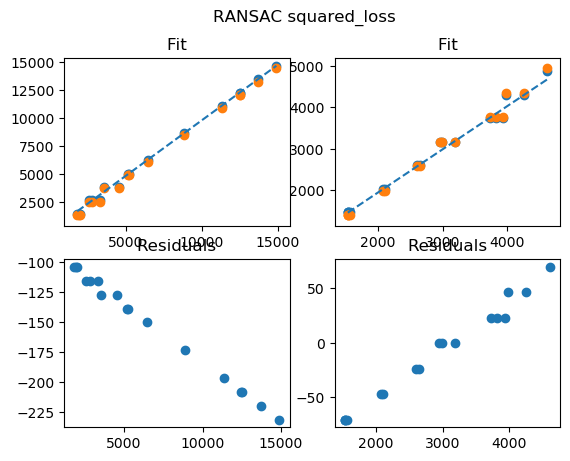

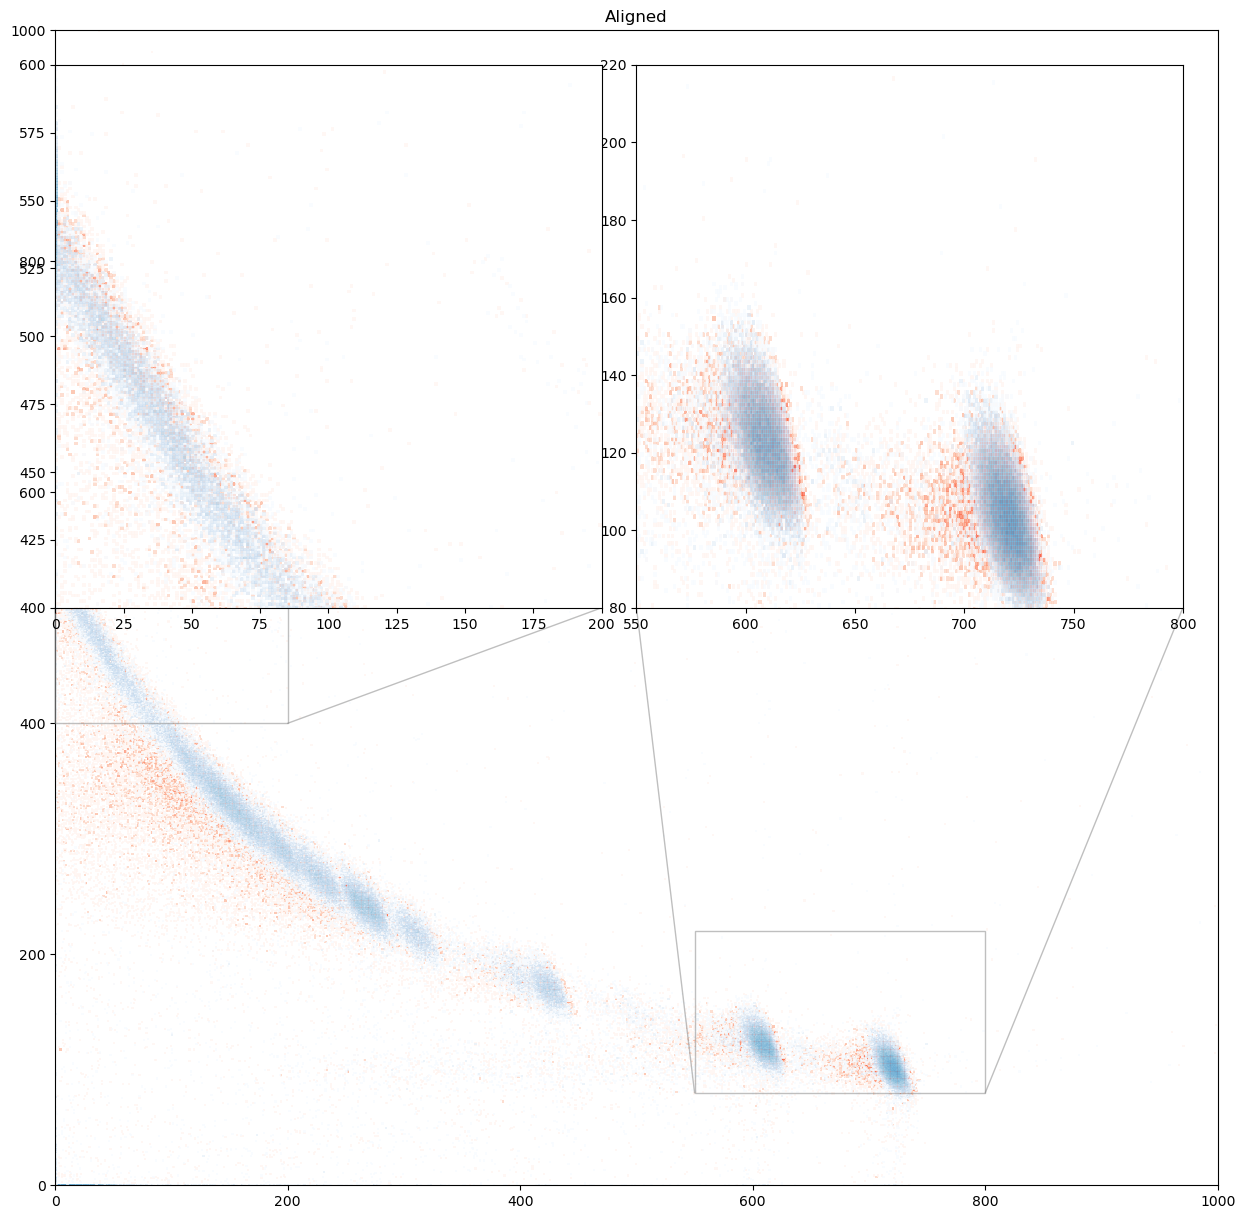

bump


In [19]:
root = "/home/erdos/master/sortering/"
@time reference = CSV.read(root*"sirius/medeb1f8.csv", header=["e", "Δe"], datarow=2) |> DataFrame;
@time target = CSV.read(root*"sirius/medeb7f8.csv", header=["e", "Δe"], datarow=2) |> DataFrame;
compare_methods(reference, target)

In [23]:
import PyPlot
PyPlot.close()

In [9]:
using PyCall
opt = pyimport("scipy.optimize")
opt.least_squares

PyObject <function least_squares at 0x7fdb721c94c0>

In [15]:
using PyCall
PyCall.py"""
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

def alpha_map(name):
    # Choose colormap
    cmap = pl.cm.get_cmap(name)

    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:, :] = my_cmap[-1]

    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

    # Create new colormap
    my_cmap = ListedColormap(my_cmap)
    return my_cmap
"""
cmap = PyCall.py"alpha_map"("Blues")
println(getproperty(cmap, 0))

MethodError: MethodError: no method matching getproperty(::PyPlot.ColorMap, ::Int64)
Closest candidates are:
  getproperty(::PyPlot.ColorMap, !Matched::Symbol) at /home/erdos/.julia/packages/PyPlot/4wzW1/src/colormaps.jl:25
  getproperty(::PyPlot.ColorMap, !Matched::AbstractString) at /home/erdos/.julia/packages/PyPlot/4wzW1/src/colormaps.jl:26
  getproperty(!Matched::Tuple, ::Int64) at Base.jl:17
  ...

In [10]:
?opt.least_squares

Solve a nonlinear least-squares problem with bounds on the variables.

    Given the residuals f(x) (an m-dimensional real function of n real
    variables) and the loss function rho(s) (a scalar function), `least_squares`
    finds a local minimum of the cost function F(x)::

        minimize F(x) = 0.5 * sum(rho(f_i(x)**2), i = 0, ..., m - 1)
        subject to lb <= x <= ub

    The purpose of the loss function rho(s) is to reduce the influence of
    outliers on the solution.

    Parameters
    ----------
    fun : callable
        Function which computes the vector of residuals, with the signature
        ``fun(x, *args, **kwargs)``, i.e., the minimization proceeds with
        respect to its first argument. The argument ``x`` passed to this
        function is an ndarray of shape (n,) (never a scalar, even for n=1).
        It must return a 1-d array_like of shape (m,) or a scalar. If the
        argument ``x`` is complex or the function ``fun`` returns complex
        residuals

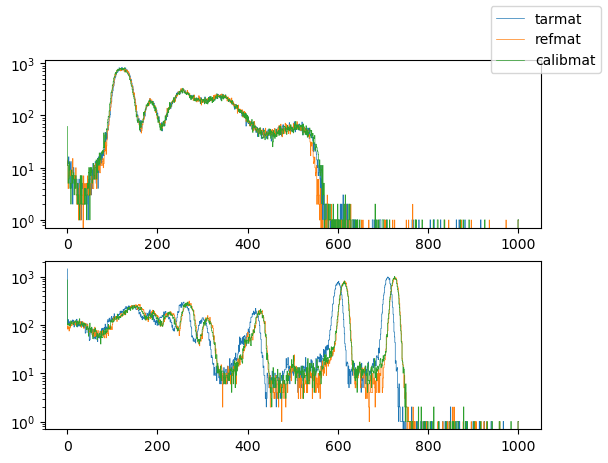

PyObject <matplotlib.legend.Legend object at 0x7fdb16c30eb0>

In [54]:
fig, ax = PyPlot.subplots(nrows=2)
mats = (tarmat, refmat, calibmat)
labels = ("tarmat", "refmat", "calibmat")
for i in 1:3
    y = sum(mats[i], dims=1)'
    x = 1:length(y)
    ax[1].step(x, y, label=labels[i], lw=0.5)
    y = sum(mats[i], dims=2)
    x = 1:length(y)
    ax[2].step(x, y, lw=0.5)
end
ax[1].set_yscale("log")
ax[2].set_yscale("log")
fig.legend()

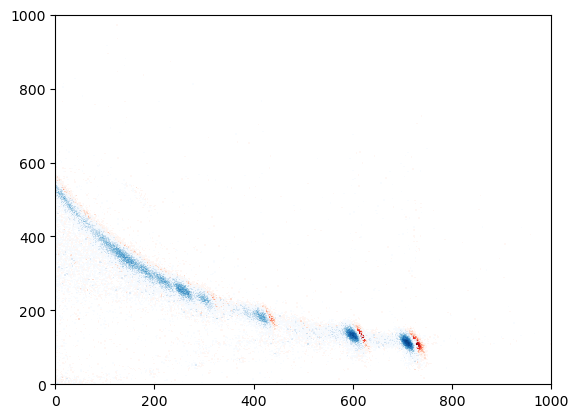

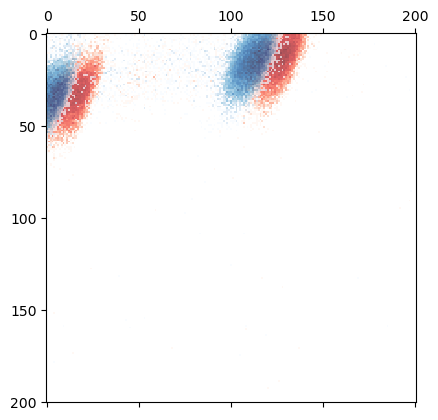

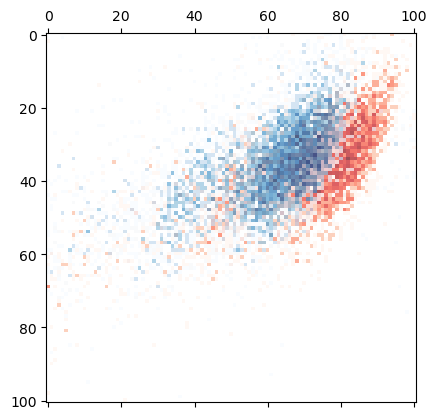

PyObject <matplotlib.image.AxesImage object at 0x7fdb1816d3a0>

In [55]:
fig, ax = plt.subplots()
ax.pcolormesh(refmat', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.pcolormesh(tarmat', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)
fig, ax = plt.subplots()
ax.matshow(refmat[600:800, 100:300]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.matshow(tarmat[600:800, 100:300]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)
fig, ax = plt.subplots()
ax.matshow(refmat[350:450, 150:250]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.matshow(tarmat[350:450, 150:250]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)

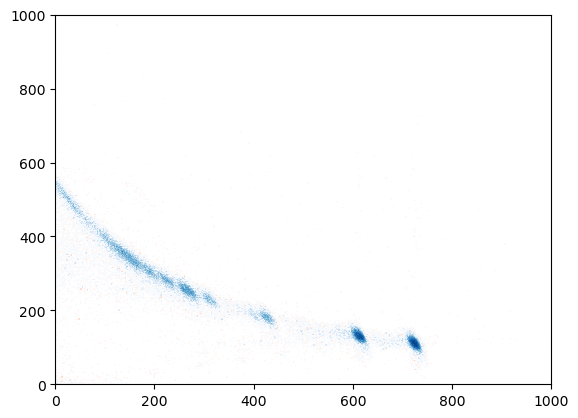

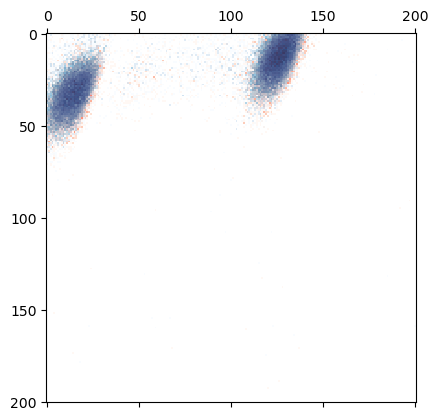

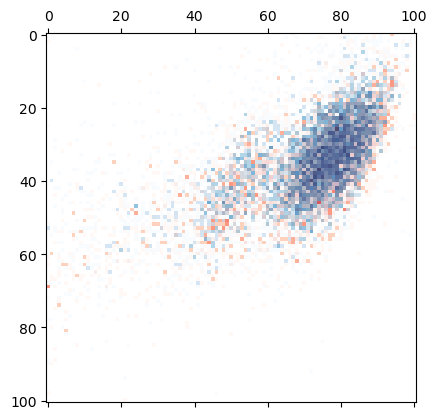

PyObject <matplotlib.image.AxesImage object at 0x7fdb191aea30>

In [56]:
fig, ax = plt.subplots()
ax.pcolormesh(refmat', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.pcolormesh(calibmat', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)
fig, ax = plt.subplots()
ax.matshow(refmat[600:800, 100:300]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.matshow(calibmat[600:800, 100:300]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)
fig, ax = plt.subplots()
X, Y = 350:450, 150:250
ax.matshow(refmat[X, Y]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Reds", alpha=0.7)
ax.matshow(calibmat[X, Y]', norm=PyPlot.matplotlib.colors.LogNorm(),
                  cmap="Blues", alpha=0.7)

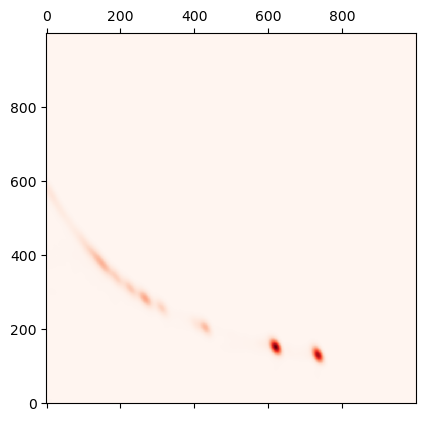

In [149]:
using ImageFiltering
fig, ax = plt.subplots()
r = imfilter(refmat, Kernel.gaussian(7))
ax.matshow(r |> transpose, cmap="Reds")
ax.invert_yaxis()

# mat = neighbourreduce(refmat, width=9, threshold=50)
# @show minimum(mat)
# @show maximum(mat)
# fig, ax = plt.subplots()
# ax.matshow(mat .|> log10 |> transpose)
# ax.invert_yaxis()

## Notes
Method is doomed to fail for low data regions. Reject region if number of counts
is less than N.

Use subarrays for regions.

I think I must apply smoothing to get anything meaningful

Use large regions or small regions? Trade-off between amount of features and neglibability of the higher order terms.

Gainshifting on the indices is impossible. Must instead gainshift on the axis and plot accordingly.

Heatmap is a pure pain, it doesn't take care of the ranges correctly. Use matplotlib pcolormesh? I think so.
Need to take care of all the bookkeeping with index-to-value mapping and the sort when
"gainshifting" the axis.

It is incredibly frustrating to use, save and load OMatrices. Would it be better to instead save the raw events as a long csv of to columns with the E and $\Delta$E? 
 - YES! Wonderful idea. Everything is a thousand times easier now.
  - ~~[ ] Create a plotting recipe for OMatrix~~
  - ~~[ ] Create a gainshift for OMatrix~~
  - Bin the dataframe-data into sizable histograms
  - Featurefit
  - Calibrate the raw data
  - Compare
  - [ ] Fix finding of minimum
  - [ ] Try smoothing
  - Coeffx == coeffy??
  - Idiot! I must use the same binning when binning the data!
  - Feature align on the summed axes instead?
  
 Think I've done it. Key was to normalize the matrices and use a gaussian smoothing. This
 makes the metric (L2 by default) give meaningful answers
 
Some selected regions have more counts than the threshold, but all of them are random noise. Causes random fitting Remove random-looking regions. An alternative way is to using
weighted regression. How to find weights?

Have to find a way to weigh points by their uncertainty in potential surface minimization. 

I have found some methods to penalize flat/unsharp potentials which can be used as
weights in regression. Weighted regression seems to works ok.

Created a "noise removal kernel" where points are removed if the sum of neighboring counts
is below a threshold. Seems to work nicely. 

- [ ] Look at the effect of neighbor noise reduction
- [ ] Look into *robust* regression
- [ ] Analyze the *residuals*
- [ ] Iterate regression a second time using much smaller search window?
 - This can be a general technique for both 1D and 2D. Iterative linear transformations
 until a perfect fit, pick some points and map them forward/backward. Use those points
 in final regression of chosen order